# Analytics Engineer Challenge
The objective of this challenge is to assess the ability to develop a simple ML repo,
following good coding practices and considering an appropriate structure.

In [1]:
## Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import databaseconfig as cfg
import functions as fn

# For creating a Pipeline
from sklearn.pipeline import make_pipeline
# Data Preprocessing
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Data Processing

In [2]:
# Selecting training features
data = cfg.train
data.head()

,Id,SalePrice,OverallQual,FullBath,YearBuilt,GrLivArea,GarageCars
0,1,208500,7,2,2003,1710,2
1,2,181500,6,2,1976,1262,2
2,3,223500,7,2,2001,1786,2
3,4,140000,7,1,1915,1717,3
4,5,250000,8,2,2000,2198,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Id           1460 non-null   int64
 1   SalePrice    1460 non-null   int64
 2   OverallQual  1460 non-null   int64
 3   FullBath     1460 non-null   int64
 4   YearBuilt    1460 non-null   int64
 5   GrLivArea    1460 non-null   int64
 6   GarageCars   1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


### Analysis of Target variable

In [4]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

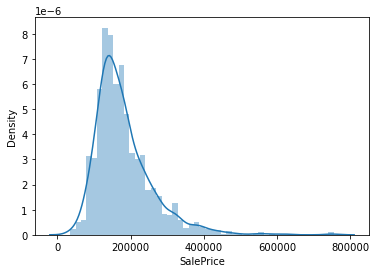

In [5]:
 sns.distplot(data['SalePrice'])

As we see, we have a positive skew, we must fix it.

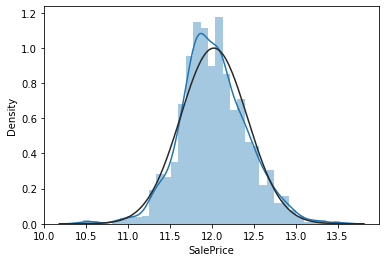

In [6]:
data['SalePrice'] = np.log1p(data['SalePrice'])
sns.distplot(data['SalePrice'], fit=norm)

### Correlation Matrix between features

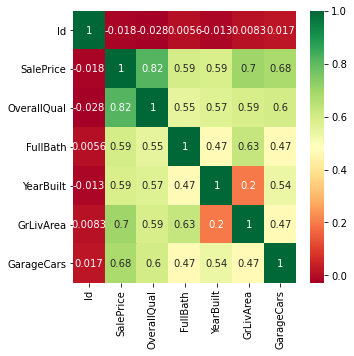

In [7]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat,annot=True,cmap="RdYlGn")

Let's show the features and the number of Missing values

In [8]:
Total = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([Total], axis=1, keys=['Total Null Values'])
missing_data.head(25)

,Total Null Values
GarageCars,0
GrLivArea,0
YearBuilt,0
FullBath,0
OverallQual,0
SalePrice,0
Id,0


We can see that the columns tha we selected don't have any missing values.

#### Fix The Skewness in the other features


In [9]:
numeric_feats = data.dtypes[data.dtypes != 'object'].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew

GrLivArea    1.365156
YearBuilt   -0.612831
dtype: float64

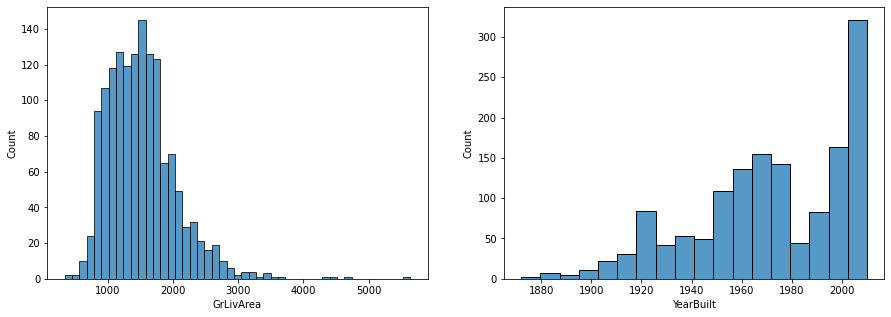

In [10]:
# Histogram of bith variables
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a kernel density estimate plot of age for visualizing the distribution of observations in the dataset
sns.histplot(data=data, x='GrLivArea', ax=axes[0])
sns.histplot(data=data, x='YearBuilt', ax=axes[1])

In [11]:
data = fn.fix_skewness(data)

## Data Training

In [12]:
x_train, x_test, y_train, y_test = fn.split_data(data)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1145, 5) (315, 5) (1145,) (315,)


## Model Training

In [13]:
xgb_reg = fn.model(x_train, y_train)
xgb_reg 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBoost stands for "Extreme Gradient Boosting" and it is an implementation of gradient boosting trees algorithm. The XGBoost is a popular supervised machine learning model with characteristics like computation speed, parallelization, and performance.
It is designed to be both computationally efficient and highly effective, perhaps more effective than other open-source implementations.
Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network.

XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems. 

Source:https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/#:~:text=Number%20of%20Features-,Extreme%20Gradient%20Boosting%20Algorithm,or%20regression%20predictive%20modeling%20problems.&text=Trees%20are%20added%20one%20at,errors%20made%20by%20prior%20models.

## Model Evaluation

In [14]:
performance = fn.model_performance(x_train, x_test, y_train, y_test, xgb_reg)

Train Data Model Performance
Root Mean Squared Error: 19889.46778720299
Mean Absolute Error: 13822.181956195418
R^2: 0.940136741929859 

Test Data Model Performance
Root Mean Squared Error: 28842.592131938178
Mean Absolute Error: 21585.551078869048
R^2: 0.839477621171329


+ **Root mean squared error (RMSE)**: RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation. In this case price have a difference of +-28842.59.
+ **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. In this case price have a difference of +-21585.55.
+ **R-squared (R2)**: R2 measures measure of how close the data are to the fitted regression line. Is a statistical measure of fit that indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model.It is the percentage of the response variable variation that is explained by a linear model. When is 0.00, it indicates that the model explains none of the variability of the response data around its mean. 1.00 indicates that the model explains all the variability of the response data around its mean. In this case is .819, which means that 81.9% of the data fit the regression model.


## Individual predictions
**Implementing an alternative evaluation method:**

Let’s call “method A” your prediction method implemented in the previous section. For a
random 50% of your individual predictions, you will generate a prediction using “method B”,
which we define now.
Method B simply consists of predicting a random value for the SalePrice variable. However,
this random value must be drawn from the distribution of the SalePrice variable. Implement
this functionality on your individual predictions, in the way you find more convenient.


In [15]:
user_list, predA, predB = fn.individual_pred(data, xgb_reg)

Enter id or ids separated by space: 3 5 7


The predicted price for id  [3, 5, 7]  with method A is:  [217636.0, 283969.0, 239361.0]
The predicted price for id  [3, 5, 7]  with method B is:  [191750.0, 196778.0, 279300.0]


In [17]:
alternative_eval = fn.alt_eval(user_list, predA, predB)

Bad prediction percentage with method A 66.66666666666666 %
Bad prediction percentage with method B 100.0 %


What would be your approach to decide whether the difference in those percentages is significant or not?

The bigger the difference is, it means that one model is better at predicting than the other. But this doesn't mean that the one that has a greater good prediction percentage is the best model ever created and can be implemented in prodcution. If the bad prediction percentage is above 10%, the model isn't considered a good model, and therefore it wouldn't be advisable to implement it.